Found 7910 files belonging to 2 classes.
✅ Classes Found: ['Benign', 'Malignant']
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 121s 1us/step
Epoch 1/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - accuracy: 0.7772 - loss: 0.4907 - val_accuracy: 0.8649 - val_loss: 0.3357
Epoch 2/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 822s 2s/step - accuracy: 0.8730 - loss: 0.3244 - val_accuracy: 0.8964 - val_loss: 0.2664
Epoch 3/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 826s 2s/step - accuracy: 0.8924 - loss: 0.2731 - val_accuracy: 0.9148 - val_loss: 0.2287
Epoch 4/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.9099 - loss: 0.2335 - val_accuracy: 0.9205 - val_loss: 0.2060
Epoch 5/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 1315s 3s/step - accuracy: 0.9157 - loss: 0.2223 - val_accuracy: 0.9255 - val_loss: 0.1847


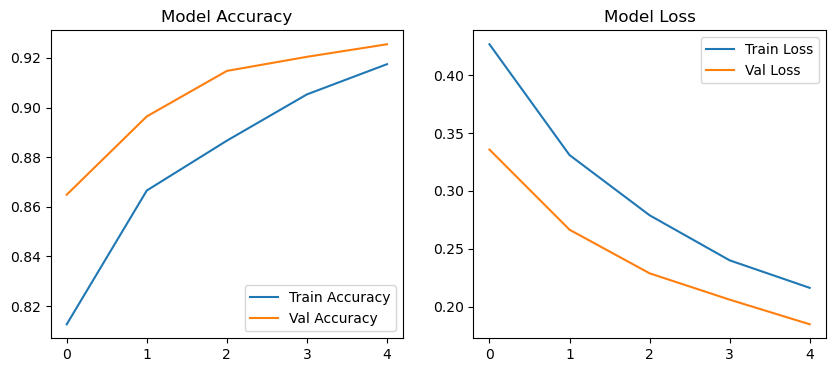

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Enable mixed precision for speed (optional)
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# ===============================
# 1️⃣ Load Dataset from Directory
# ===============================
train_dir = "BreakHis/train/"

batch_size = 16  # Reduce batch size for CPU
img_size = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

# Check classes
class_names = train_dataset.class_names
print(f"✅ Classes Found: {class_names}")

# ===============================
# 2️⃣ Normalize & Split Dataset
# ===============================
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y)).cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)

# Split into train & validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_ds = train_dataset.take(train_size)
val_ds = train_dataset.skip(train_size)

# ===============================
# 3️⃣ Load ResNet50V2 (Optimized for CPU)
# ===============================
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers
base_model.trainable = False

# ===============================
# 4️⃣ Build Model
# ===============================
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),  # Reduce dense layer size
    layers.Dropout(0.3),  # Reduce dropout for CPU efficiency
    layers.Dense(1, activation="sigmoid")
])

# ===============================
# 5️⃣ Compile Model with XLA Acceleration
# ===============================
tf.config.optimizer.set_jit(True)  # Enable XLA acceleration

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reduce LR for CPU stability
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ===============================
# 6️⃣ Train Model
# ===============================
epochs = 5  # Reduce epochs for faster training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# ===============================
# 7️⃣ Plot Accuracy & Loss
# ===============================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Model Loss")
plt.show()
